<a href="https://colab.research.google.com/github/sagi-vaknin/Object-Detection/blob/main/Object_Detection_Model_ResNet18_Backbone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation of Neural Network for Object Detection


*   Project by Sagi Vaknin



In [ ]:
## All Relevant Imports
import torch, os, shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import cv2

from torch.nn import Dropout, Identity, Linear, Module, ReLU, Sequential, Sigmoid, LogSoftmax
from collections import OrderedDict
from PIL import Image, ImageDraw
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset

!pip install roboflow
from roboflow import Roboflow

In [ ]:
rf = Roboflow(api_key="YOUR_KEY")
project = rf.workspace("brad-dwyer").project("oxford-pets")
dataset = project.version(2).download("tensorflow")
class_labels = []

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.GaussianBlur(kernel_size=(5,9)),
    transforms.RandomPosterize(p=0.2,bits=2),
    transforms.RandomGrayscale(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Helper methods:

In [ ]:
# preprocess the dataset into class folders
def preprocess_data(set_type):
    annotations_df = pd.read_csv(f'Oxford-Pets-2/{set_type}/_annotations.csv')
    root_dir = f'Oxford-Pets-2/{set_type}'
    processed_root_dir = f'processed_dataset/{set_type}'

    classes = annotations_df['class'].unique()
    for class_name in classes:
        class_dir = os.path.join(processed_root_dir, class_name)
        os.makedirs(class_dir, exist_ok=True)

    for filename in os.listdir(root_dir):
        if filename.endswith('.jpg'):
            annotation_row = annotations_df[annotations_df['filename'] == filename]
            if not annotation_row.empty:
                class_name = annotation_row.iloc[0]['class']  # Get the class name
                source_path = os.path.join(root_dir, filename)
                destination_dir = os.path.join(processed_root_dir, class_name)
                destination_path = os.path.join(destination_dir, filename)

                shutil.copy(source_path, destination_path)
                print(f"Copied {filename} to {destination_dir}")
            else:
                print(f"No annotation found for {filename}")

In [ ]:
def prepare_image(image): #helper method for preparing an image for plotting
  plt_image = image.clone()
  for t, m, s in zip(plt_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]):
      t.mul_(s).add_(m)

  image_np = plt_image.permute(1, 2, 0).cpu().numpy()

  return image_np.clip(0, 1)

In [ ]:
def display_examples(examples): #helper method for displaying 4 random examples of the inference

  fig, axes = plt.subplots(1, 4, figsize=(16, 8))

  for i in range(4):
      image, prediction, gt = examples[i]
      image = prepare_image(image)
      axes[i].imshow(image)
      axes[i].axis('off')

      axes[i].set_title(f"Prediction: {class_labels[prediction]}, Ground Truth: {class_labels[gt]}", fontsize=10)

### Showing the backbone inference capabilities on the dataset

-   This is done to show the backbone capabilities prior to training or creating the object detector model itself

In [ ]:
preprocess_data("test")
test_dataset = datasets.ImageFolder(root='processed_dataset/test', transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
class_labels = test_dataset.classes

In [ ]:
model = models.resnet18(pretrained=True)

#change num of classes from 1000 (imagenet) into 2 (dog,cat)
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = model.to(device)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 109MB/s]


In [ ]:
count = correct_predictions = total_predictions = 0
examples = []

#put model in inference mdoe
model.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        probabilities = torch.softmax(outputs, dim=1)
        _, predicted_indices = torch.max(probabilities, dim=1)

        correct_predictions += torch.sum(predicted_indices == labels).item()
        # capture 4 images as random examples
        if count < 4:
          examples.append((images[0], predicted_indices[0], labels[0]))
          count += 1

        total_predictions += len(images)

accuracy = correct_predictions / total_predictions
print(f"Total images: {total_predictions}, Correct predictions: {correct_predictions}, Accuracy: {accuracy * 100:.2f}%")

Total images: 368, Correct predictions: 222, Accuracy: 60.33%


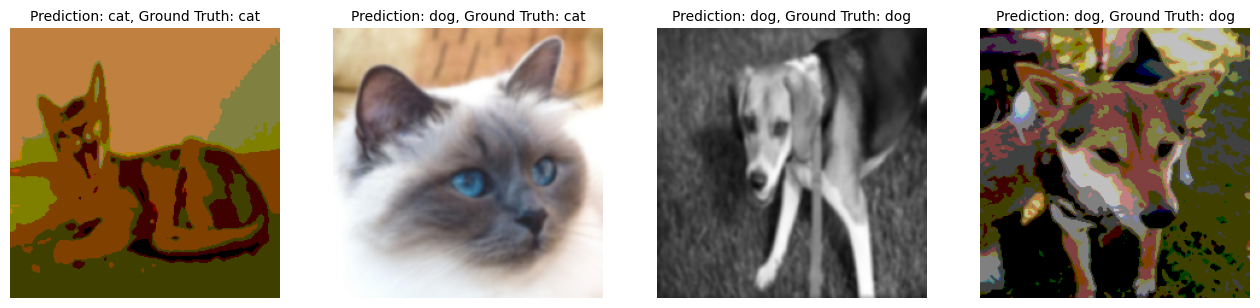

In [ ]:
display_examples(examples) #examples after transformation

### Object Detection Model Implementation

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        original_width, original_height = image.size

        bbox = self.dataframe.iloc[idx, 4:8].values.astype(int)
        class_label = self.dataframe.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)
            bbox = self.normalize_bbox(bbox, original_width, original_height) #change to range [0,1] based on original sizes
        return image, bbox, class_label

    def get_bbox(self,idx):
        bbox = self.dataframe.iloc[idx, 4:8].values.astype(int)
        return bbox

    def normalize_bbox(self, bbox, w, h):
        x1, y1, x2, y2 = bbox
        norm_x1 = x1 / w
        norm_y1 = y1 / h
        norm_x2 = x2 / w
        norm_y2 = y2 / h
        return torch.tensor([norm_x1, norm_y1, norm_x2, norm_y2])


In [ ]:
def fix_annotations(folder_path, dataset):
    dataset.drop_duplicates(subset=['filename'], keep='first', inplace=True)
    for index, row in dataset.iterrows():
        file_path = os.path.join(folder_path, row['filename'])
        if not os.path.exists(file_path):
            dataset.drop(index, inplace=True)

    dataset.reset_index(drop=True, inplace=True)
    return dataset

In [ ]:
class ObjectDetector(Module):
    def __init__(self, baseModel, numClasses):
        super(ObjectDetector, self).__init__()

        self.baseModel = baseModel
        self.numClasses = numClasses

        self.regressor = Sequential(
                Linear(baseModel.fc.in_features, 128),
                ReLU(),
                Linear(128, 64),
                ReLU(),
                Linear(64, 32),
                ReLU(),
                Linear(32, 4),
                Sigmoid())

        self.classifier = Sequential(OrderedDict([
            ('fc1', Linear(baseModel.fc.in_features, 256)),
            ('relu1', ReLU()),
            ('fc2', Linear(256, numClasses)),
            ('output', LogSoftmax(dim=1))
            ]))

        self.baseModel.fc = Identity()

    def forward(self, x):
        features = self.baseModel(x)

        bboxes = self.regressor(features)

        classLogits = self.classifier(features)

        return bboxes, classLogits

In [ ]:
def init_dataframe(split):
    dataframe = pd.read_csv(f"Oxford-Pets-2/{split}/_annotations.csv")
    dataframe = fix_annotations(f"Oxford-Pets-2/{split}", dataframe)
    return dataframe

In [ ]:
def train(object_detector, criterion_bbox, criterion_class, optimizer, trainloader, device, epoch=3):
    print('Entered Training')

    for e in range(epoch):
        correct = total = 0
        running_loss = 0.0

        object_detector.train()

        for i, data in enumerate(trainloader, 0):
            inputs, bboxes, labels = data
            _, _, h, w = inputs.size()

            inputs = inputs.to(device)
            bboxes = bboxes.to(device)

            bboxes_pred, class_logits = object_detector(inputs)

            class_probs = torch.softmax(class_logits, dim=1)
            class_indices = torch.argmax(class_probs, dim=1)

            predicted_labels = tuple(class_labels[label] for label in class_indices) #prediction labels (as labels)

            indices = [class_labels.index(label) for label in labels] #ground truth labels as indices
            bboxes_loss = criterion_bbox(bboxes_pred, bboxes)

            indices = torch.tensor(indices).to(device)
            labels_loss = criterion_class(class_logits, indices)

            loss = bboxes_loss + labels_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            total += len(labels)
            correct += sum(1 for x, y in zip(predicted_labels, labels) if x == y)

        # Print statistics
        print(f'Epoch {e + 1}, Loss: {running_loss / len(trainloader)}')
        accuracy = f'{100 * correct / total:.2f}%'
        print(f'Accuracy on the training set: {accuracy}')

    print('Finished Training')
    return object_detector, optimizer

In [ ]:
train_losses = []

train_dataframe = init_dataframe("train")
train_dataset = CustomDataset(train_dataframe,'Oxford-Pets-2/train',transform)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

train_model = models.resnet18(pretrained=True)

object_detector = ObjectDetector(train_model, 2)

for param in train_model.parameters():
  param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
object_detector = object_detector.to(device)

optimizer = torch.optim.Adam(object_detector.parameters(), lr=1e-4)


criterion_bbox = torch.nn.SmoothL1Loss()
criterion_class = torch.nn.NLLLoss()


object_detector, optimizer = train(object_detector, criterion_bbox, criterion_class, optimizer, train_dataloader, device, epoch=3)

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.


Entered Training
Epoch 1, Loss: 0.44045056968524
Accuracy on the training set: 81.13%
Epoch 2, Loss: 0.2594806518682433
Accuracy on the training set: 91.23%
Epoch 3, Loss: 0.21553738262923788
Accuracy on the training set: 91.89%
Finished Training


In [ ]:
def validate(object_detector, criterion_bbox, criterion_class, val_loader, device):
    print('Entered Validation')
    object_detector.eval()
    with torch.no_grad():
        correct = total = 0
        running_loss = 0.0

        for data in val_loader:
            inputs, bboxes, labels = data
            inputs = inputs.to(device)
            bboxes = bboxes.to(device)

            bboxes_pred, class_logits = object_detector(inputs)

            class_probs = torch.softmax(class_logits, dim=1)
            class_indices = torch.argmax(class_probs, dim=1)
            predicted_labels = tuple(class_labels[label] for label in class_indices)

            indices = [class_labels.index(label) for label in labels]
            indices = torch.tensor(indices).to(device)

            labels_loss = criterion_class(class_logits, indices)
            bboxes_loss = criterion_bbox(bboxes_pred, bboxes)
            loss = bboxes_loss + labels_loss

            running_loss += loss.item()
            total += len(labels)
            correct += sum(1 for x, y in zip(predicted_labels, labels) if x == y)

        # Print statistics
        print(f'Loss on the validation set: {running_loss / len(val_loader)}')
        accuracy = f'{100 * correct / total:.2f}%'
        print(f'Accuracy on the validation set: {accuracy}')
        avg_loss = running_loss / len(val_loader)

    print('Finished Validation')
    return avg_loss, accuracy

In [ ]:
val_losses = []

val_dataframe = init_dataframe("valid")
val_dataset = CustomDataset(val_dataframe, 'Oxford-Pets-2/valid', transform)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

# Call the validate function
avg_val_loss, val_accuracy = validate(object_detector, criterion_bbox, criterion_class, val_dataloader, device)

Entered Validation
Loss on the validation set: 0.19764288180952863
Accuracy on the validation set: 91.85%
Finished Validation


In [ ]:
def test(object_detector, criterion_bbox, criterion_class, testloader, device):
    print('Entered Testing')
    object_detector.eval()  # Set the model to evaluation mode

    with torch.no_grad():  # Disable gradient calculation during testing
        correct = total = 0
        running_loss = 0.0

        for data in testloader:

            inputs, bboxes, labels = data
            _, _, h, w = inputs.size()
            inputs = inputs.to(device)
            bboxes = bboxes.to(device)

            bboxes_pred, class_logits = object_detector(inputs)

            class_probs = torch.softmax(class_logits, dim=1)
            class_indices = torch.argmax(class_probs, dim=1)
            predicted_labels = tuple(class_labels[label] for label in class_indices)

            indices = [class_labels.index(label) for label in labels]
            indices = torch.tensor(indices).to(device)

            labels_loss = criterion_class(class_logits, indices)
            bboxes_loss = criterion_bbox(bboxes_pred, bboxes)
            loss = bboxes_loss + labels_loss

            running_loss += loss.item()
            total += len(labels)
            correct += sum(1 for x, y in zip(predicted_labels, labels) if x == y)

        # Print statistics
        print(f'Loss on the test set: {running_loss / len(testloader)}')
        accuracy = f'{100 * correct / total:.2f}%'
        print(f'Accuracy on the test set: {accuracy}')
        avg_loss = running_loss / len(testloader)

    print('Finished Testing')
    return avg_loss, accuracy

In [ ]:
test_dataframe = init_dataframe("test")
test_dataset = CustomDataset(test_dataframe,'Oxford-Pets-2/test',transform)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

avg_loss, accuracy = test(object_detector, criterion_bbox, criterion_class, test_dataloader, device)

Entered Testing
Loss on the test set: 0.1952686985088258
Accuracy on the test set: 92.39%
Finished Testing


### Show AABB and Classification exmaples on random images:

In [ ]:
def adjust_bbox_to_new_dimensions(bbox, new_width, new_height):
    """
    Adjust bounding box coordinates to new image dimensions.
    """
    bbox = bbox.tolist()[0]

    norm_x1, norm_y1, norm_x2, norm_y2 = bbox
    x1 = norm_x1 * new_width
    y1 = norm_y1 * new_height
    x2 = norm_x2 * new_width
    y2 = norm_y2 * new_height
    return (int(x1), int(y1), int(x2), int(y2))

In [ ]:
def process_frame(x, model, transform):
    image = Image.open(x).convert('RGB')
    w, h = image.size
    draw = ImageDraw.Draw(image)

    # Preprocess the frame
    frame = transform(image)
    frame = frame.unsqueeze(0)

    # Perform inference
    with torch.no_grad():
        model.eval()
        frame = frame.to(device)
        bboxes, labels = model(frame)

        class_probs = torch.softmax(labels, dim=1)
        confidence, _ = torch.max(class_probs, dim=1)
        confidence = round(confidence.item(),4)
        print(f"{confidence = }")
    if confidence <= 0.8:
        return cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    # Adjust bounding boxes to match frame dimensions
    bboxes = adjust_bbox_to_new_dimensions(bboxes, w, h)

    # Draw bounding boxes and labels
    class_labels = ['cat', 'dog']
    max_index = torch.argmax(labels)
    label = class_labels[max_index.item()]

    if label == "cat":
        draw.rectangle(bboxes, outline='red' ,fill=None)
        text_position = (bboxes[0], bboxes[1] - 20)
        label = f"{label}: {confidence}"
        draw.text(text_position, label,fill="red")
    elif label == "dog":
        draw.rectangle(bboxes, outline='blue', fill=None)
        text_position = (bboxes[0], bboxes[1] - 20)
        label = f"{label}: {confidence}"
        draw.text(text_position, label, fill="blue")


    # Convert PIL image back to OpenCV format
    frame_with_boxes = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    return frame_with_boxes

### Samples from the validation dataset:

confidence = 0.9792


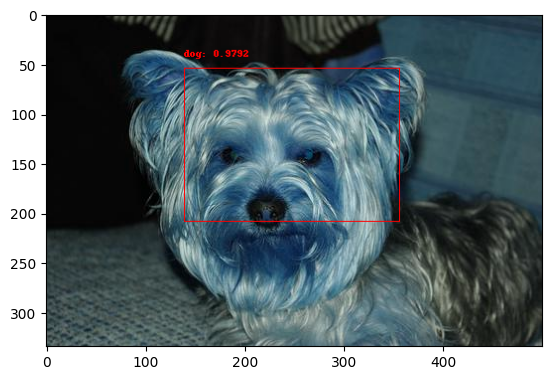

In [ ]:
frame_test_1 = process_frame('Oxford-Pets-2/valid/yorkshire_terrier_188_jpg.rf.ae4a9b05c6f6e95d24578bac39f79d07.jpg', object_detector, transform)
plt.imshow(frame_test_1)

confidence = 0.9962


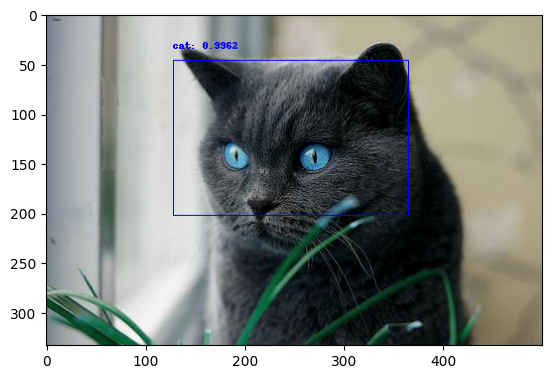

In [ ]:
frame_test_2 = process_frame('Oxford-Pets-2/valid/British_Shorthair_130_jpg.rf.740277ec11f8207a8da1b56320659aa6.jpg', object_detector, transform)
plt.imshow(frame_test_2)

### Random tests:


confidence = 0.5257


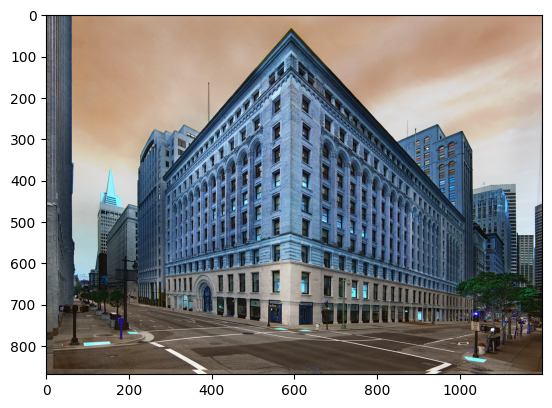

In [ ]:
frame_test_3 = process_frame('./building.jpeg', object_detector, transform)
plt.imshow(frame_test_3)

confidence = 0.6022


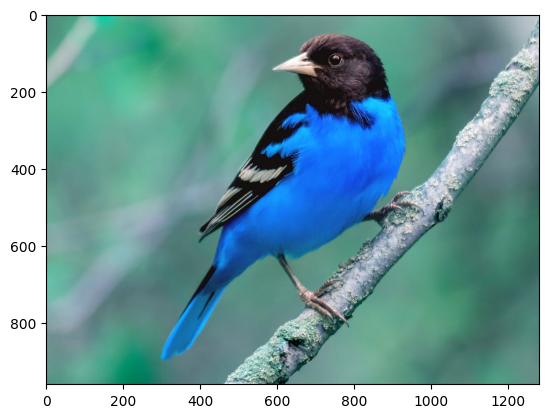

In [ ]:
frame_test_4 = process_frame('./bird.jpeg', object_detector, transform)
plt.imshow(frame_test_4)

confidence = 0.6381


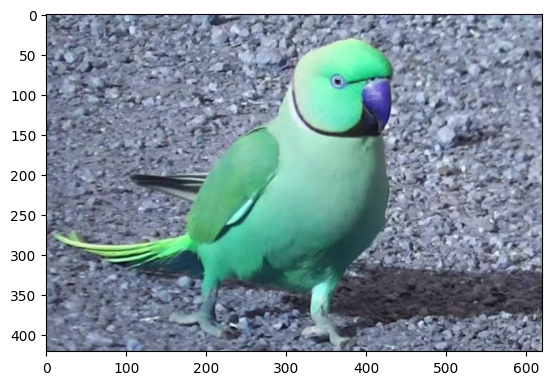

In [ ]:
frame_test_5 = process_frame('./parrot.jpeg', object_detector, transform)
plt.imshow(frame_test_5)